In [1]:
import astropy
import numpy as np
import pandas as pd

## Section1 : Parameters of the simulation: cosmology, box size, geometry, origin of lightcone etc 

In [2]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

## Box Size (in Mpc)
BoxLength = 2800. 

#ORIGIN OF THE LIGHTCONE
origin = [BoxLength/4,BoxLength/4,BoxLength/4]


## Fullsky: True or False
FullSky = True

#DIRECTION VECTOR OF THE LIGHTCONE
if not FullSky:
    ra = np.radians(31) 
    piby2_minus_dec  = np.radians(80)  ## 80 is the theta in spherical coordinates
    direction_vector=[np.cos(ra)*np.sin(piby2_minus_dec),np.sin(ra)*np.sin(piby2_minus_dec),np.cos(piby2_minus_dec)]

#COSMOLOGY
om = 0.304611 ### cosmology of flaminggo D3A
ol = 0.693922
H = 68.1 * u.km / u.s / u.Mpc
h = H.value/100

m_nu = [0.0,0.02,0.04] *u.eV
cosmo = FlatLambdaCDM(H0=H, Om0=om, Ob0=0.049, Tcmb0=2.725)
redshift_file='/nfs/pic.es/user/s/sramakri/Flamingo/flamingo_params.txt'
df=pd.read_csv(redshift_file,usecols=[0,2],names=['snap','z'],skiprows=1,delimiter=' ')
redshift = {str(snap): [z] for snap, z in zip(df.sort_values('snap', ascending=False)['snap'], df.sort_values('snap', ascending=False)['z'])}

#redshift = {"144":[0],"143":[0.009522],'142':[0.019134],'141':[0.028838]}

for i, label in enumerate(redshift.keys()):
    redshift[label].append(cosmo.comoving_distance(redshift[label][0]).value)
comov_dist = np.zeros([len(redshift)])
redshift_array = np.zeros([len(redshift)])
for i,snapshot in enumerate(redshift):
    comov_dist[i] = cosmo.comoving_distance(redshift[snapshot][0]).value
    redshift_array[i] = redshift[snapshot][0]

comov_dist_mid = np.pad((comov_dist[1:]+comov_dist[0:-1])/2,(1,1))
comov_dist_mid[-1] = comov_dist[-1]

#BUFFER REGION
buffer_comovD = 1/h   ## approx 1/h Mpc assuming haloes don't go farther than this between snapshots, obtained from the rough estimate in Section 1

print (redshift)

{'144': [0.0, 0.0], '143': [0.009522, 41.826713470251796], '142': [0.019134, 83.86264064982566], '141': [0.028838, 126.11015663129425], '140': [0.038634, 168.56277531881085], '139': [0.048524, 211.2225640148051], '138': [0.05, 217.57187177503067], '137': [0.058507, 254.07852770994853], '136': [0.068586, 297.13675281026264], '135': [0.078761, 340.3903067486082], '134': [0.089032, 383.83221308728224], '133': [0.099402, 427.46804683875337], '132': [0.1, 429.9774611816535], '131': [0.10987, 471.2863833627282], '130': [0.120438, 515.2883097052181], '129': [0.131106, 559.4664431546292], '128': [0.141876, 603.8215876501212], '127': [0.152749, 648.3502557249908], '126': [0.163725, 693.0447856293879], '125': [0.174805, 737.901535751655], '124': [0.185992, 782.9247828205471], '123': [0.197284, 828.0985638850425], '122': [0.2, 838.923152327746], '121': [0.208684, 873.4269254679826], '120': [0.220193, 918.9057419024422], '119': [0.237662, 987.3926645608075], '118': [0.261343, 1079.1880596566828], 

## Section 2: Approximate buffer region estimate

In [3]:
lookback_time = np.zeros([len(redshift)])
for i,snapshot in enumerate(redshift):
    lookback_time[i] = cosmo.lookback_time(redshift[snapshot][0]).value
delta_t = lookback_time[1:]-lookback_time[:-1]
oneGigaYear_to_sec = 3.15e16  ## seconds
km_to_Mpc = 3.24078e-20 
rough_estimate_of_how_much_haloes_move_in_Mpc = (delta_t)*oneGigaYear_to_sec*350*km_to_Mpc  ### 300 km/s approximate the average velocity dispersion of the local universe
print (delta_t,rough_estimate_of_how_much_haloes_move_in_Mpc.max())

[0.13577556 0.13516768 0.13456678 0.13394471 0.13332884 0.01973642
 0.11294225 0.13204758 0.13139547 0.13072298 0.13006808 0.00744258
 0.12193756 0.12869682 0.1279935  0.12729432 0.12658698 0.12586009
 0.12512555 0.12440543 0.12364407 0.02945426 0.09344278 0.12214196
 0.18176887 0.23962473 0.23646635 0.13863514 0.09460423 0.22997454
 0.22666349 0.2232998  0.21991139 0.21647508 0.21301775 0.20951853
 0.02966121 0.17635614 0.20247979 0.19893057 0.19537189 0.19180617
 0.18823016 0.1382274  0.04643705 0.18109389 0.17753802 0.17398823
 0.17045735 0.16693775 0.1634505  0.15997455 0.15653849 0.0495884
 0.10353404 0.14974853 0.14640223 0.14309652 0.13982873 0.13660336
 0.13342422 0.13028565 0.12719455 0.18509884 0.17841686 0.01105559
 0.16084701 0.16556281 0.1593961  0.15340505 0.14759462 0.14195772
 0.06567629 0.07082629 0.13121811 0.12611051 0.12117293 0.11640413
 0.10064528 0.0111568  0.10736303 0.10308213 0.09895646 0.09498184
 0.05471159 0.03644475 0.08747363 0.08392928 0.08052146 0.07724

## Section 3: Generating points inside the 4 boxes, compute coordinates and angles

In [4]:
def generate_grid_points_in_volume(xmin, xmax, ymin, ymax, zmin, zmax):
    x = np.linspace(xmin, xmax,400)
    y = np.linspace(ymin, ymax,400)
    z = np.linspace(zmin, zmax,400)
    xx,yy,zz = np.meshgrid(x,y,z)
    flattened_grid = np.column_stack([xx.flatten(), yy.flatten(),zz.flatten()])
    return flattened_grid.T

In [5]:
points1 = generate_grid_points_in_volume(0, BoxLength, 0, BoxLength, 0, BoxLength)+0.1
points2 = generate_grid_points_in_volume(0, - BoxLength, 0, BoxLength, 0, BoxLength)+0.1
points3 = generate_grid_points_in_volume(0, BoxLength, 0, - BoxLength, 0, BoxLength)+0.1
points4 = generate_grid_points_in_volume(0, BoxLength, 0, BoxLength, 0, - BoxLength)+0.1

In [6]:
points_r1 = np.sqrt((points1[0]-origin[0])**2+(points1[1]-origin[1])**2+(points1[2]-origin[2])**2) 
points_r2 = np.sqrt((points2[0]-origin[0])**2+(points2[1]-origin[1])**2+(points2[2]-origin[2])**2) 
points_r3 = np.sqrt((points3[0]-origin[0])**2+(points3[1]-origin[1])**2+(points3[2]-origin[2])**2) 
points_r4 = np.sqrt((points4[0]-origin[0])**2+(points4[1]-origin[1])**2+(points4[2]-origin[2])**2) 

In [7]:
### loop over redshifts and ask at each redshift, the gridpoints falling between the two comoving distances, and within theta from the direction vector
if not FullSky:
    cosangle1 = np.dot(points1.T,direction_vector)/points_r1
    cosangle2 = np.dot(points2.T,direction_vector)/points_r2
    cosangle3 = np.dot(points3.T,direction_vector)/points_r3
    cosangle4 = np.dot(points4.T,direction_vector)/points_r4

## Section4: Dataframe with info regarding comoving distance,boxes replicated,etc

In [8]:
columns = ['comovD_Min(Mpchinv)', 'comovD_Max(Mpchinv)','theta(radians)','buffer_comovD(Mpchinv)','buffer_theta(radians)','direction_vector_x','direction_vector_y','direction_vector_z','Kind_of_join', 'halodir1','halodir2','field1','field2','Box1(w/ buffer)','Box2(w/ buffer)','Box3(w/ buffer)','Box4(w/ buffer)']
df = pd.DataFrame(0,columns=columns,index=np.arange(46*2))

In [9]:
## compute theta_max given a square_coverage_area
A = 50  ## A is the area coverage in square degrees
cos_theta_max =  1-(A/2)*np.pi/180**2 ## theta is the angle made with the cone
theta = np.arccos(cos_theta_max)## in radians
print (theta)   ## in radians

0.06964263622787888


In [10]:
df['Kind_of_join'] = 'left'
df['theta(radians)'] = theta
df['buffer_comovD(Mpchinv)'] = buffer_comovD
df['direction_vector_x'] = 0.844145
df['direction_vector_y'] =0.507213
df['direction_vector_z'] = 0.173648
for i in range(46):
    df.at[2*i,'comovD_Min(Mpchinv)'] = comov_dist[i]
    df.at[2*i,'comovD_Max(Mpchinv)'] = comov_dist_mid[i+1]
    df.at[2*i,'halodir1'] = 50-i
    df.at[2*i,'halodir2'] = 50-i-1
    df.at[2*i,'field1'] = 'last_mainleaf_depthfirst_id'
    df.at[2*i,'field2'] = 'last_mainleaf_depthfirst_id'
    buffer_theta = 1/(comov_dist_mid[i]+5)
    df.at[2*i,'buffer_theta(radians)'] = buffer_theta
    df.at[2*i,'Box1(w/ buffer)'] = ( ((cosangle1>np.cos(theta+buffer_theta))&(points_r1>comov_dist[i]-buffer_comovD)&(points_r1<comov_dist_mid[i+1]+buffer_comovD)).any())
    df.at[2*i,'Box2(w/ buffer)'] = ( ((cosangle2>np.cos(theta+buffer_theta))&(points_r2>comov_dist[i]-buffer_comovD)&(points_r2<comov_dist_mid[i+1]+buffer_comovD)).any())
    df.at[2*i,'Box3(w/ buffer)'] = ( ((cosangle3>np.cos(theta+buffer_theta))&(points_r3>comov_dist[i]-buffer_comovD)&(points_r3<comov_dist_mid[i+1]+buffer_comovD)).any())
    df.at[2*i,'Box4(w/ buffer)'] = ( ((cosangle4>np.cos(theta+buffer_theta))&(points_r4>comov_dist[i]-buffer_comovD)&(points_r4<comov_dist_mid[i+1]+buffer_comovD)).any())
    
    df.at[2*i + 1, 'comovD_Min(Mpchinv)'] = comov_dist_mid[i+1]
    df.at[2*i + 1, 'comovD_Max(Mpchinv)'] = comov_dist[i+1]
    df.at[2*i + 1, 'halodir1'] = 50-i-1
    df.at[2*i + 1, 'halodir2'] =50-i
    df.at[2*i + 1, 'field1'] = 'desc_id'
    df.at[2*i + 1, 'field2'] = 'id'
    buffer_theta = 1/(comov_dist_mid[i+1]+5)
    df.at[2*i + 1,'buffer_theta(radians)'] = buffer_theta
    df.at[2*i + 1, 'Box1(w/ buffer)'] = ( ((cosangle1>np.cos(theta+buffer_theta))&(points_r1>comov_dist_mid[i+1]-buffer_comovD)&(points_r1<comov_dist[i+1]+buffer_comovD)).any())
    df.at[2*i + 1, 'Box2(w/ buffer)'] = ( ((cosangle2>np.cos(theta+buffer_theta))&(points_r2>comov_dist_mid[i+1]-buffer_comovD)&(points_r2<comov_dist[i+1]+buffer_comovD)).any())
    df.at[2*i + 1, 'Box3(w/ buffer)'] = ( ((cosangle3>np.cos(theta+buffer_theta))&(points_r3>comov_dist_mid[i+1]-buffer_comovD)&(points_r3<comov_dist[i+1]+buffer_comovD)).any())
    df.at[2*i + 1, 'Box4(w/ buffer)'] = ( ((cosangle4>np.cos(theta+buffer_theta))&(points_r4>comov_dist_mid[i+1]-buffer_comovD)&(points_r4<comov_dist[i+1]+buffer_comovD)).any())

/tmp/ipykernel_62/4019458492.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.913356735125898' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[2*i,'comovD_Max(Mpchinv)'] = comov_dist_mid[i+1]
/tmp/ipykernel_62/4019458492.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'last_mainleaf_depthfirst_id' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[2*i,'field1'] = 'last_mainleaf_depthfirst_id'
/tmp/ipykernel_62/4019458492.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'last_mainleaf_depthfirst_id' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[2*i,'field2'] = 'last_mainleaf_depthfirst_id'
/t

NameError: name 'cosangle1' is not defined

In [ ]:
df.to_pickle('join_table.pkl')

In [61]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df

,comovD_Min(Mpchinv),comovD_Max(Mpchinv),theta(radians),buffer_comovD(Mpchinv),buffer_theta(radians),direction_vector_x,direction_vector_y,direction_vector_z,Kind_of_join,halodir1,halodir2,field1,field2,Box1(w/ buffer),Box2(w/ buffer),Box3(w/ buffer),Box4(w/ buffer)
0,0.000000,32.808360,0.069643,1,0.200000,0.844145,0.507213,0.173648,left,50,49,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
1,32.808360,65.616720,0.069643,1,0.026449,0.844145,0.507213,0.173648,left,49,50,desc_id,id,True,False,False,False
2,65.616720,99.552373,0.069643,1,0.026449,0.844145,0.507213,0.173648,left,49,48,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
3,99.552373,133.488025,0.069643,1,0.009565,0.844145,0.507213,0.173648,left,48,49,desc_id,id,True,False,False,False
4,133.488025,203.093873,0.069643,1,0.009565,0.844145,0.507213,0.173648,left,48,47,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
5,203.093873,272.699720,0.069643,1,0.004806,0.844145,0.507213,0.173648,left,47,48,desc_id,id,True,False,False,False
6,272.699720,339.238616,0.069643,1,0.004806,0.844145,0.507213,0.173648,left,47,46,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
7,339.238616,405.777512,0.069643,1,0.002905,0.844145,0.507213,0.173648,left,46,47,desc_id,id,True,False,False,False
8,405.777512,474.786357,0.069643,1,0.002905,0.844145,0.507213,0.173648,left,46,45,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
9,474.786357,543.795202,0.069643,1,0.002084,0.844145,0.507213,0.173648,left,45,46,desc_id,id,True,False,False,False


In [41]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df

,comovD_Min(Mpchinv),comovD_Max(Mpchinv),theta(radians),buffer_comovD(Mpchinv),buffer_theta(radians),Kind_of_join,halodir1,halodir2,field1,field2,"Box1(0,0,0)(w/ buffer)","Box2(L,0,0)(w/ buffer)","Box3(L,L,0)(w/ buffer)","Box4(2L,L,0)(w/ buffer)"
0,0.000000,32.808360,0.069643,1,0.030480,left,50,49,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
1,32.808360,65.616720,0.069643,1,0.015240,left,49,50,desc_id,id,True,False,False,False
2,65.616720,99.552373,0.069643,1,0.010045,left,49,48,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
3,99.552373,133.488025,0.069643,1,0.007491,left,48,49,desc_id,id,True,False,False,False
4,133.488025,203.093873,0.069643,1,0.004924,left,48,47,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
5,203.093873,272.699720,0.069643,1,0.003667,left,47,48,desc_id,id,True,False,False,False
6,272.699720,339.238616,0.069643,1,0.002948,left,47,46,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
7,339.238616,405.777512,0.069643,1,0.002464,left,46,47,desc_id,id,True,False,False,False
8,405.777512,474.786357,0.069643,1,0.002106,left,46,45,last_mainleaf_depthfirst_id,last_mainleaf_depthfirst_id,True,False,False,False
9,474.786357,543.795202,0.069643,1,0.001839,left,45,46,desc_id,id,True,False,False,False


## Section5: (Optional) Table for downloading data from Original Catalog (FullSky)

In [11]:
columns = ['comovD_Min(Mpc)', 'comovD_Max(Mpc)','buffer_comovD(Mpc)','halodir','Box1(0,0,0)(w/ buffer)','Box2(-L,0,0)(w/ buffer)','Box3(0,-L,0)(w/ buffer)','Box4(0,0,-L)(w/ buffer)']
df = pd.DataFrame(0,columns=columns,index=np.arange(len(redshift)),dtype=np.float64)
df['Box1(0,0,0)(w/ buffer)'] = df['Box1(0,0,0)(w/ buffer)'].astype(bool)
df['Box2(-L,0,0)(w/ buffer)'] = df['Box2(-L,0,0)(w/ buffer)'].astype(bool)
df['Box3(0,-L,0)(w/ buffer)'] = df['Box3(0,-L,0)(w/ buffer)'].astype(bool)
df['Box4(0,0,-L)(w/ buffer)'] = df['Box4(0,0,-L)(w/ buffer)'].astype(bool)
df['halodir']=df['halodir'].astype('string')

In [12]:
comov_dist_padded = np.pad(comov_dist,(1,1))
comov_dist_padded[-1] =comov_dist_padded[-2] 

In [13]:
df['buffer_comovD(Mpc)'] = buffer_comovD
df['origin_x'] = BoxLength/4
df['origin_y'] = BoxLength/4
df['origin_z'] = BoxLength/4
df['BoxSize'] = BoxLength

for i,snap in enumerate(redshift):
    df.at[i,'comovD_Min(Mpc)'] = comov_dist_padded[i]
    df.at[i,'comovD_Max(Mpc)'] = comov_dist_padded[i+2]
    df.at[i,'halodir'] = snap
    df.at[i,'Box1(0,0,0)(w/ buffer)'] = ((points_r1>comov_dist_padded[i]-buffer_comovD)&(points_r1<comov_dist_padded[i+2]+buffer_comovD)).any()
    df.at[i,'Box2(-L,0,0)(w/ buffer)'] = ((points_r2>comov_dist_padded[i]-buffer_comovD)&(points_r2<comov_dist_padded[i+2]+buffer_comovD)).any()
    df.at[i,'Box3(0,-L,0)(w/ buffer)'] = ((points_r3>comov_dist_padded[i]-buffer_comovD)&(points_r3<comov_dist_padded[i+2]+buffer_comovD)).any()
    df.at[i,'Box4(0,0,-L)(w/ buffer)'] = ((points_r4>comov_dist_padded[i]-buffer_comovD)&(points_r4<comov_dist_padded[i+2]+buffer_comovD)).any()    

In [14]:
df

,comovD_Min(Mpc),comovD_Max(Mpc),buffer_comovD(Mpc),halodir,"Box1(0,0,0)(w/ buffer)","Box2(-L,0,0)(w/ buffer)","Box3(0,-L,0)(w/ buffer)","Box4(0,0,-L)(w/ buffer)",origin_x,origin_y,origin_z,BoxSize
0,0.000000,41.826713,1.468429,144,True,False,False,False,700.0,700.0,700.0,2800.0
1,0.000000,83.862641,1.468429,143,True,False,False,False,700.0,700.0,700.0,2800.0
2,41.826713,126.110157,1.468429,142,True,False,False,False,700.0,700.0,700.0,2800.0
3,83.862641,168.562775,1.468429,141,True,False,False,False,700.0,700.0,700.0,2800.0
4,126.110157,211.222564,1.468429,140,True,False,False,False,700.0,700.0,700.0,2800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
140,11318.144640,11434.217026,1.468429,4,False,False,False,False,700.0,700.0,700.0,2800.0
141,11376.734779,11490.611873,1.468429,3,False,False,False,False,700.0,700.0,700.0,2800.0
142,11434.217026,11545.938932,1.468429,2,False,False,False,False,700.0,700.0,700.0,2800.0
143,11490.611873,11600.218108,1.468429,1,False,False,False,False,700.0,700.0,700.0,2800.0


In [15]:
df

,comovD_Min(Mpc),comovD_Max(Mpc),buffer_comovD(Mpc),halodir,"Box1(0,0,0)(w/ buffer)","Box2(-L,0,0)(w/ buffer)","Box3(0,-L,0)(w/ buffer)","Box4(0,0,-L)(w/ buffer)",origin_x,origin_y,origin_z,BoxSize
0,0.000000,41.826713,1.468429,144,True,False,False,False,700.0,700.0,700.0,2800.0
1,0.000000,83.862641,1.468429,143,True,False,False,False,700.0,700.0,700.0,2800.0
2,41.826713,126.110157,1.468429,142,True,False,False,False,700.0,700.0,700.0,2800.0
3,83.862641,168.562775,1.468429,141,True,False,False,False,700.0,700.0,700.0,2800.0
4,126.110157,211.222564,1.468429,140,True,False,False,False,700.0,700.0,700.0,2800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
140,11318.144640,11434.217026,1.468429,4,False,False,False,False,700.0,700.0,700.0,2800.0
141,11376.734779,11490.611873,1.468429,3,False,False,False,False,700.0,700.0,700.0,2800.0
142,11434.217026,11545.938932,1.468429,2,False,False,False,False,700.0,700.0,700.0,2800.0
143,11490.611873,11600.218108,1.468429,1,False,False,False,False,700.0,700.0,700.0,2800.0


In [16]:
df.to_pickle('/nfs/pic.es/user/s/sramakri/jpynb/lc_interpolator_dask_version/dask_region_selector/select_table.pkl')

In [17]:
string

NameError: name 'string' is not defined

In [ ]:
Memory = np.array([0.002,0.02,0.018,0.056,0.107,0.201,0.297,0.390,0.602,0.797,0.992,1.3,1.5,1.9,2.3,2.6,3,3.5,4,4.5,5,5.5,5.8,6.1,6.9,7.3,7.1,7.5,8,8.3,8.5,8.8,8.6,8.4,11,12.6,12,11,11.63,11.24,8.5,6.4,4.2,2.6,1.5,0.699,0.147])

In [ ]:
Memory.shape

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(redshift_array,Memory)
plt.xlabel('redshift')
plt.ylabel('Memory in GB')

## Estimate of the Size

In [19]:
path = '/nfs/pic.es/user/s/sramakri/jpynb/'
import sys
sys.path.append(path)
from colossus.cosmology import cosmology
from colossus.lss import mass_function
import CosmologyLibraryM as cm
ns = 0.9667
sig8 = 0.8159
cosmolib = cm.cosmology(Omega_matter=om,Omega_lambda=ol,H_0=100*h,sigma_8=sig8,ns=ns)

k,Tfn = np.loadtxt(path+'camb_96239641_transfer_1.dat',unpack=True,usecols=[0,1])

In [20]:
df = df.set_index('halodir')

In [21]:
def Size_LCparts_in_GB(M_min,float_size,no_of_columns,flag=0):
    m = np.logspace(np.log10(M_min),15,30)
    dlnm = (np.log(m[1:])-np.log(m[0:-1])).mean()
    m_mid = np.sqrt(m[1:]*m[:-1])
    tinkermf = np.zeros([len(redshift),len(m_mid)])
    comov_dist = np.zeros([len(redshift)])
    N_halo_const = 4*np.pi/3
    Vol = np.zeros([len(redshift)])
    for i,key in enumerate(redshift.keys()):
        tinkermf[i,:] = (cosmolib.T08(m_mid,k,Tfn,z=redshift[key][0])).flatten()
        Vol[i] = N_halo_const* ((df.loc[key]['comovD_Max(Mpc)']+1.4)**3-(df.loc[key]['comovD_Min(Mpc)']-1.4)**3)*np.sum(tinkermf[i,:]*dlnm)*h**3  
    if flag==0:
        return Vol*float_size*no_of_columns/1e9
    else:
        return Vol

In [22]:
redshift_file='/nfs/pic.es/user/s/sramakri/Flamingo/flamingo_params.txt'
zdf=pd.read_csv(redshift_file,usecols=[0,2],names=['snap','z'],skiprows=1,delimiter=' ')

In [23]:
zdf = zdf.set_index('snap')

In [24]:
zdf['memoryGB'] = 0
zdf['memoryGB'] = zdf['memoryGB'].astype(float)

In [25]:
zdf.loc[144,'memoryGB'] = 0.0099
zdf.loc[143,'memoryGB'] = 0.058
zdf.loc[142,'memoryGB'] = 0.172
zdf.loc[141,'memoryGB'] = 0.128
zdf.loc[140,'memoryGB'] = 0.583
zdf.loc[139,'memoryGB'] = 0.433
zdf.loc[138,'memoryGB'] = 0.540
zdf.loc[137,'memoryGB'] = 1.2
zdf.loc[136,'memoryGB'] = 1.8
zdf.loc[135,'memoryGB'] = 2.4
zdf.loc[134,'memoryGB'] = 2.9
zdf.loc[133,'memoryGB'] = 1.8
zdf.loc[132,'memoryGB'] = 2.0
zdf.loc[131,'memoryGB'] = 4.2
zdf.loc[130,'memoryGB'] = 5.2
zdf.loc[129,'memoryGB'] = 6.2
zdf.loc[128,'memoryGB'] = 7.1
zdf.loc[127,'memoryGB'] = 8.3
zdf.loc[126,'memoryGB'] = 9.5
zdf.loc[125,'memoryGB'] = 11
zdf.loc[124,'memoryGB'] = 13
zdf.loc[123,'memoryGB'] = 8.2
zdf.loc[122,'memoryGB'] = 7.4
zdf.loc[121,'memoryGB'] = 14
zdf.loc[120,'memoryGB'] = 22
zdf.loc[119,'memoryGB'] = 35
zdf.loc[118,'memoryGB'] = 45
zdf.loc[117,'memoryGB'] = 41
zdf.loc[116,'memoryGB'] = 28
zdf.loc[115,'memoryGB'] = 43
zdf.loc[114,'memoryGB'] = 64





In [26]:
s = Size_LCparts_in_GB(1.6e10,4,20,1)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(zdf['z'],s[::-1]/3.5e6,marker='.',label='forecast with Tinker2008')
plt.scatter(zdf['z'],zdf['memoryGB'],marker='x',color='red',label='actual filesize')
plt.xlim([0.009,10])
plt.ylim([0.009,1800])
plt.yscale('log')
plt.ylabel('Size in GB')
plt.xlabel('Redshift')
plt.xscale('log')
plt.legend(loc='lower right') 

In [66]:
memory_per_halo = zdf['memoryGB']*1e9/s[::-1]

In [67]:
print (memory_per_halo)

snap
0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
          ...    
140    328.405567
141    127.278981
142    370.797048
143    405.094732
144    530.876941
Name: memoryGB, Length: 145, dtype: float64


In [29]:
size_predict = Size_LCparts_in_GB(1.6e10,4,21,0)

In [123]:
size_predict.sum()

15573.910566363349

In [100]:
s.sum()/3.5e6

52972.48491960323

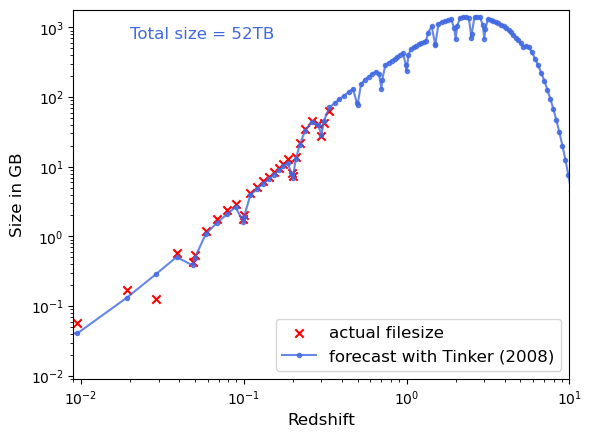

In [40]:
import matplotlib.pyplot as plt
plt.scatter(zdf['z'],zdf['memoryGB'],marker='x',color='red',label='actual filesize')
plt.plot(zdf['z'],s[::-1]/3.5e6,marker='.',label='forecast with Tinker (2008)',color='royalblue',alpha=0.8)
#plt.plot(zdf['z'],size_predict[::-1],color='green',alpha=0.6,linestyle='dashed',label='forecast minimal (21 cols)')
plt.xlim([0.009,10])
plt.ylim([0.009,1800])
plt.yscale('log')
plt.ylabel('Size in GB',fontsize=12)
plt.xlabel('Redshift',fontsize=12)
plt.xscale('log')
plt.legend(loc='lower right',fontsize=12) 
plt.text(0.02,700,'Total size = 52TB',color='royalblue',fontsize=12)
plt.savefig('spacerequirements-flamingo.png')
#plt.text(0.02,400,'Total memory=15TB',color='green',alpha=0.6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'c' is not defined

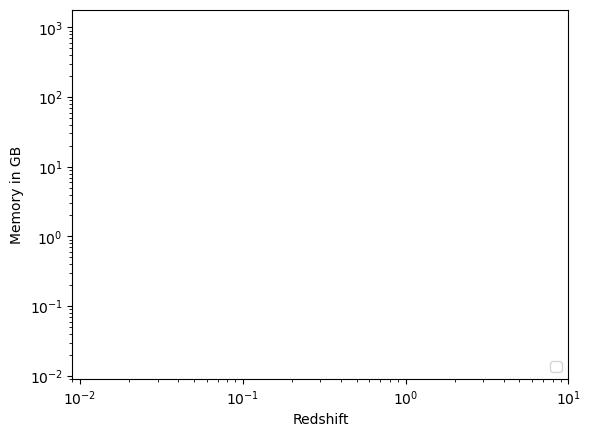

In [126]:
plt.xlim([0.009,10])
plt.ylim([0.009,1800])
plt.yscale('log')
plt.ylabel('Memory in GB')
plt.xlabel('Redshift')
plt.xscale('log')
plt.legend(loc='lower right') 
plt.text(0.02,100,'Total memory=15TB',c)

In [102]:
size_predict.max()

416.99372158553496

In [17]:
df.loc['144']['comovD_Max(Mpc)']

41.826713470251796

In [77]:
zdf.columns

Index(['z', 'memoryGB'], dtype='object')

In [57]:
om

0.304611

In [58]:
ol

0.693922